In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# !unzip '/content/drive/MyDrive/CV/license-plate-detection-with-coordinate .zip' -d '/content/drive/MyDrive/CV'


In [ ]:
# for filename in os.listdir('/content/drive/MyDrive/CV/yolo_images2/txt_files'):
#   idx = 0
#   if 'jpg' in filename:
#     print(filename)
#   else:
#     idx +=1
# print(idx)


1


In [ ]:
import utils

In [ ]:
import os
import shutil
directory = '/content/drive/MyDrive/CV/yolo_images2'

txt_directory = os.path.join(directory, 'txt_files')
os.makedirs(txt_directory, exist_ok=True)

jpg_directory = os.path.join(directory, 'jpg_files')
os.makedirs(jpg_directory, exist_ok=True)

for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    if filename.endswith('.txt'):
        shutil.move(file_path, os.path.join(txt_directory, filename))

    elif filename.endswith('.jpg'):
        shutil.move(file_path, os.path.join(jpg_directory, filename))


In [ ]:
image_folder = '/content/drive/MyDrive/CV/yolo_images2/jpg_files'
label_folder = '/content/drive/MyDrive/CV/yolo_images2/txt_files'

jpg_files = sorted(os.listdir(image_folder))
txt_files = sorted(os.listdir(label_folder))

print("Số lượng tệp JPEG:", len(jpg_files))
print("Số lượng tệp TXT:", len(txt_files))



Số lượng tệp JPEG: 4165
Số lượng tệp TXT: 4165


In [ ]:
!pip install utils

In [ ]:
import os
import numpy as np
import torch
from PIL import Image
import torchvision
import cv2
import matplotlib.pyplot as plt
import utils
import torch.nn as nn
import torch.nn.functional as F
import copy
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

In [ ]:
ISIZE = (800, 800)

#Imagenet statistics
imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])

## Anchor Box Specs
ratios = [0.5, 1, 2]
anchor_scales = [8, 16, 32]

In [ ]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[0], bb[1]), bb[2]-bb[0], bb[3]-bb[1], color=color,
                         fill=False, lw=3)

def show_corner_bbs(im, bbs):
    #im = np.asarray(im).astype(int).transpose(1,2,0)
    im = np.asarray(im).transpose(1,2,0)
    im = unnormalize(im)
    plt.imshow(im)
    for bb in bbs:
        plt.gca().add_patch(create_corner_rect(bb))
def normalize(im):
    #im = im.astype(np.float32)/255.
    im = im/255.
    """Normalizes images with Imagenet stats."""
    return (im - imagenet_stats[0])/imagenet_stats[1]

def unnormalize(im):
    im = im.astype(np.float32)
    """Normalizes images with Imagenet stats."""
    im = (im *imagenet_stats[1] +  imagenet_stats[0])*255.
    im = im.astype(np.int)
    return im

In [ ]:
def train_val_dataset(dataset, val_split=0.1):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets
def train_val_dataset_1(dataset, val_split=0.1):
    train_idx, val_idx = train_test_split(list(range(50)), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

In [ ]:
def evaluate_feature_map(imgs, req_features):
    k = imgs.clone()
    for m in req_features:
        k = m(k)
    return k

def plot_feature_map(k, img_idx, row=64, col=8):
    fig = plt.figure(figsize=(20,160))
    fig.tight_layout()
    for i in range(row):
        for j in range(col):
            ind = i*col + j
            ax = fig.add_subplot(row,col,ind+1,xticks=[],yticks=[])
            ax.imshow(k[img_idx,ind,:,:].detach().cpu())
            ax.text(3, 6, ind, fontdict={'weight': 'bold', 'size': 16}, color="y" )
    fig.suptitle("feature map")

def plot_imges_with_bboxes(imgs, bboxes, col=4):
    num_imgs = len(imgs)
    row = int(np.ceil(float(len(imgs))/col).item())
    print("row: %s"%row)
    print("imgs: ", num_imgs)
    fig = plt.figure(figsize=(2*col,2*row))
    fig.tight_layout()
    for i in range(row):
        for j in range(col):
            ind = i*col + j
            if ind < num_imgs:
                img = imgs[ind]
                bbs = bboxes[ind]
                img = np.asarray(img).transpose(1,2,0)
                img = unnormalize(img)
                ax = fig.add_subplot(row,col,ind+1,xticks=[],yticks=[])
                ax.imshow(img)
                for bb in bbs:
                    plt.gca().add_patch(create_corner_rect(bb))
            #ax.text(3, 6, ind, fontdict={'weight': 'bold', 'size': 16}, color="y" )
    fig.suptitle("Images")

def pred_bbox_to_xywh(bbox, anchors):
    print("bbox: ", bbox.shape)
    print("anchors: ", anchors.shape)
    anc_height = anchors[:, 2] - anchors[:, 0]
    anc_width = anchors[:, 3] - anchors[:, 1]
    anc_ctr_y = anchors[:, 0] + 0.5 * anc_height
    anc_ctr_x = anchors[:, 1] + 0.5 * anc_width

    bbox_numpy = bbox.detach().cpu().data.numpy()
    dy = bbox_numpy[:, 0::4]
    dx = bbox_numpy[:, 1::4]
    dh = bbox_numpy[:, 2::4]
    dw = bbox_numpy[:, 3::4]
    ctr_y = dy * anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
    ctr_x = dx * anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis]
    h = np.exp(dh) * anc_height[:, np.newaxis]
    w = np.exp(dw) * anc_width[:, np.newaxis]

    roi = np.zeros(bbox_numpy.shape, dtype=h.dtype)
    roi[:, 0::4] = ctr_y - 0.5 * h
    roi[:, 1::4] = ctr_x - 0.5 * w
    roi[:, 2::4] = ctr_y + 0.5 * h
    roi[:, 3::4] = ctr_x + 0.5 * w

    return roi

In [ ]:
def bbox_generation(images, targets, X_FM, Y_FM):
    global ratios
    global anchor_scales
    num_batch = len(images)
    X_IMG, Y_IMG = images[0].shape[1:]
    bbox_all = [item['boxes'] for item in targets]
    labels_all = [item['labels'] for item in targets]

    #imgs_torch_all = torch.stack([item for item in images])
    #if is_cuda:
    #    imgs_torch_all = imgs_torch_all.cuda()
    #k = imgs_torch_all.clone()
    #for m in req_features:
    #    k = m(k)
    #print(k.shape)


    sub_sampling_x = int(X_IMG/X_FM)
    sub_sampling_y = int(Y_IMG/Y_FM)
    #print(X_IMG, Y_IMG, X_FM, Y_FM, sub_sampling_x,sub_sampling_y)
    anchor_base = np.zeros((len(ratios)*len(anchor_scales), 4), dtype=np.float32)

    ctr_x = np.arange(sub_sampling_x, (X_FM+1) * sub_sampling_x, sub_sampling_x)
    ctr_y = np.arange(sub_sampling_y, (Y_FM+1) * sub_sampling_y, sub_sampling_y)
    index = 0
    ctr = np.zeros((len(ctr_y)*len(ctr_y),2),dtype=np.float32)
    print(ctr.shape)
    print(ctr_x)
    print(ctr_y)
    for x in range(len(ctr_x)):
        for y in range(len(ctr_y)):
            ctr[index, 1] = ctr_x[x] - 8
            ctr[index, 0] = ctr_y[y] - 8
            index +=1
    print(ctr)
    exit()
    anchors = np.zeros((X_FM * Y_FM * 9, 4))
    index = 0
    for ctr_y, ctr_x in ctr:
        for i in range(len(ratios)):
            for j in range(len(anchor_scales)):
                h = sub_sampling_x * anchor_scales[j] * np.sqrt(ratios[i])
                w = sub_sampling_y * anchor_scales[j] * np.sqrt(1./ ratios[i])
                anchors[index, 0] = ctr_y - h / 2.
                anchors[index, 1] = ctr_x - w / 2.
                anchors[index, 2] = ctr_y + h / 2.
                anchors[index, 3] = ctr_x + w / 2.
                index += 1
    #print(anchors.shape)

    index_inside = np.where(
        (anchors[:, 0] >= 0) &
        (anchors[:, 1] >= 0) &
        (anchors[:, 2] <= Y_IMG) &
        (anchors[:, 3] <= X_IMG)
    )[0]
    #print(index_inside.shape)

    label = np.empty((len(index_inside), ), dtype=np.int32)
    label.fill(-1)
    valid_anchors = anchors[index_inside]
    #print(label.shape, valid_anchors.shape)
    #print(valid_anchors[0])

    ious_all = []
    for bx in bbox_all:
        ious = np.empty((len(label), bx.size()[0]), dtype=np.float32)
        ious.fill(0)
        for num1, i in enumerate(valid_anchors):
            ya1, xa1, ya2, xa2 = i
            anchor_area = (ya2 - ya1) * (xa2 - xa1)
            for num2, j in enumerate(bx):
                yb1, xb1, yb2, xb2 = j
                box_area = (yb2- yb1) * (xb2 - xb1)
                inter_x1 = max([xb1, xa1])
                inter_y1 = max([yb1, ya1])
                inter_x2 = min([xb2, xa2])
                inter_y2 = min([yb2, ya2])
                if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
                    iter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
                    iou = iter_area / (anchor_area+ box_area - iter_area)
                else:
                    iou = 0.
                ious[num1, num2] = iou
        ious_all.append(ious)


    gt_argmax_ious_all = []
    gt_max_ious_all = []
    for ious_ in ious_all:
        gt_argmax_ious = ious_.argmax(axis=0)
        gt_max_ious = ious_[gt_argmax_ious, np.arange(ious_.shape[1])]
        gt_argmax_ious_all.append(gt_argmax_ious)
        gt_max_ious_all.append(gt_max_ious)
    #print(gt_argmax_ious_all)
    #print(gt_max_ious_all)

    argmax_ious_all = []
    max_ious_all = []
    for ious_ in ious_all:
        argmax_ious = ious_.argmax(axis=1)
        max_ious = ious_[np.arange(len(label)), argmax_ious]
        argmax_ious_all.append(argmax_ious)
        max_ious_all.append(max_ious)
    #print(argmax_ious_all)
    #print(max_ious_all)

    gt_argmax_ious_all = []
    for gt_max_ious_, ious_ in zip(gt_max_ious_all, ious_all):
        gt_argmax_ious = np.where(ious_ == gt_max_ious_)[0]
        gt_argmax_ious_all.append(gt_argmax_ious)
    #print(gt_argmax_ious_all)

    pos_iou_threshold  = 0.7
    neg_iou_threshold = 0.3

    label_all = []
    for n in range(num_batch):
        l = copy.deepcopy(label)
        l[max_ious_all[n] < neg_iou_threshold] = 0
        l[gt_argmax_ious_all[n]] = 1
        l[max_ious_all[n] >= pos_iou_threshold] = 1
        label_all.append(l)
    #print ("label_all 0 and 1: ", sum(label_all[0]), sum(label_all[1]))

    pos_ratio = 0.5
    n_sample = 256
    n_pos = int(pos_ratio * n_sample)
    #print(n_pos)

    for n in range(num_batch):
        #print(np.sum((label_all[n] == 1)))
        pos_index = np.where(label_all[n] == 1)[0]
        #print(pos_index)
        if len(pos_index) > n_pos:
            disable_index = np.random.choice(pos_index, size=(len(pos_index) - n_pos), replace=False)
            label_all[n][disable_index] = -1
        #print(np.sum((label_all[n] == 1)))

        n_neg = n_sample - np.sum(label_all[n] == 1)
        neg_index = np.where(label_all[n] == 0)[0]
        if len(neg_index) > n_neg:
            disable_index = np.random.choice(neg_index, size=(len(neg_index) - n_neg), replace = False)
            label_all[n][disable_index] = -1
        #print(np.sum((label_all[n] == 0)))


    max_iou_bbox_all = []
    #print(bbox_all)
    for n in range(num_batch):
        max_iou_bbox_all.append(bbox_all[n][argmax_ious_all[n]])
    #print(max_iou_bbox_all[0].shape, max_iou_bbox_all[0].shape)

    #Anchor box
    height = valid_anchors[:, 2] - valid_anchors[:, 0]
    width = valid_anchors[:, 3] - valid_anchors[:, 1]
    ctr_y = valid_anchors[:, 0] + 0.5 * height
    ctr_x = valid_anchors[:, 1] + 0.5 * width
    #Ground truth
    base_height_all = []
    base_width_all = []
    base_ctr_y_all = []
    base_ctr_x_all = []
    for n in range(num_batch):
        base_height = max_iou_bbox_all[n][:, 2] - max_iou_bbox_all[n][:, 0]
        base_width = max_iou_bbox_all[n][:, 3] - max_iou_bbox_all[n][:, 1]
        base_ctr_y = max_iou_bbox_all[n][:, 0] + 0.5 * base_height
        base_ctr_x = max_iou_bbox_all[n][:, 1] + 0.5 * base_width
        base_height_all.append(base_height)
        base_width_all.append(base_width)
        base_ctr_y_all.append(base_ctr_y)
        base_ctr_x_all.append(base_ctr_x)

    #print(width[2], base_width_all[0][2])

    #Prevent devide by 0
    eps = np.finfo(height.dtype).eps
    height = np.maximum(height, eps)
    width = np.maximum(width, eps)

    #d_{} calculatrion
    anchor_locs_all = []
    for n in range(num_batch):
        dy = (base_ctr_y_all[n].numpy() - ctr_y) / height
        dx = (base_ctr_x_all[n].numpy() - ctr_x) / width
        dh = np.log(base_height_all[n].numpy()/ height)
        dw = np.log(base_width_all[n].numpy() / width)
        anchor_locs_all.append(np.vstack((dy, dx,dh, dw)).transpose())
    #print(anchor_locs_all[0][1], anchor_locs_all[0].shape)

    anchor_labels_all = []
    for n in range(num_batch):
        anchor_labels = np.empty((len(anchors),), dtype=label_all[n].dtype)
        anchor_labels.fill(-1)
        anchor_labels[index_inside] = label_all[n]
        anchor_labels_all.append(anchor_labels)
    anchor_labels_all_merge = np.stack(anchor_labels_all, 0)
    #print(sum(anchor_labels_all[0]==1), anchor_labels_all[0][0:11])
    #print(anchor_labels_all_merge.shape)
    #print(sum(anchor_labels_all_merge[0]==1))

    anchor_locations_all = []
    for n in range(num_batch):
        anchor_locations = np.empty((len(anchors), anchors.shape[1]), dtype=anchor_locs_all[n].dtype)
        anchor_locations.fill(0)
        anchor_locations[index_inside, :] = anchor_locs_all[n]
        anchor_locations_all.append(anchor_locations)
    #print(anchor_locations_all[0].shape)
    #print(type(anchor_locations_all[0]))
    anchor_locations_all_merge = np.stack(anchor_locations_all, 0)
    #print(anchor_locations_all_merge[0][0])
    #print(anchor_locations_all[0][1500])

    return anchor_locations_all_merge, anchor_labels_all_merge, anchors

In [ ]:
boxes_path= '/content/drive/MyDrive/CV/yolo_images2/txt_files/10148.txt'
with open(boxes_path, 'r') as f:
            lines = f.readlines()
            last_line = lines[-1].strip()
            parts = last_line.split()
            parts[0] = str(int(parts[0]) / 4)
            modified_line = ' '.join(parts)
print(parts)

['1.0', '0.42666650000000006', '0.5649065', '0.18333300000000002', '0.09346500000000002']


In [ ]:
boxes = []
boxes.append(float(part) for part in parts[1:])
modified_line[1]

'.'

In [ ]:
class CustomDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "jpg_files"))))
        self.boxes= list(sorted(os.listdir(os.path.join(root, "txt_files"))))
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "jpg_files", self.imgs[idx])
        boxes_path = os.path.join(self.root, "txt_files", self.boxes[idx])
        # print(boxes_path)
        img = Image.open(img_path).convert("RGB")
        img = img.resize(ISIZE)
        img = np.array(img)
        img = normalize(img)
        img = img.transpose(2, 0, 1)
        img = torch.as_tensor(img, dtype=torch.float32)
 # Load bounding box information from the TXT file
        with open(boxes_path, 'r') as f:
            lines = f.readlines()
            last_line = lines[-1].strip()
            parts = last_line.split()
            parts[0] = str(float(parts[0]) / 4)
            # modified_line = ' '.join(parts)

        box = []
        for part in parts[1:]:
          box.append(float(part))
        # x_center, y_center, width, height = line.strip().split()
        xmin = (float(box[0]) - float(box[2]/2))*800
        ymin = (float(box[1]) - float(box[3]/ 2))*800
        xmax = (float(box[0]) + float(box[2]/ 2))*800
        ymax = (float(box[1]) + float(box[3]/2))*800
        box[0], box[1], box[2], box[3] = xmin, ymin, xmax, ymax
            # box[0],box[1],boxes[2],box[3]= xmin,ymin,xmax,ymax
        boxes = []
        boxes.append(box)
        # # Convert everything into torch.Tensor
        # area= (boxes[:,2]-boxes[:,0])*(boxes[:,3]-boxes[:,1])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        image_id= torch.tensor([idx])
        labels = torch.ones((1,), dtype=torch.int64)

        # target = {}
        # target["boxes"] = boxes
        # target["labels"] = labels

        # return img, target
        # Gán nhãn và thông tin khác
        num_objs = 1
        # labels = torch.ones((num_objs,), dtype=torch.int64)
        # image_id = torch.tensor([idx])
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id,
            # "area": area
        }
        return img, target

    def __len__(self):
        return len(self.imgs)


In [ ]:
# def custom_collate_fn(batch):
#     images = []
#     targets = []

#     for img, target in batch:
#         images.append(img)
#         targets.append(target)

#     return images, targets


In [ ]:
import utils

In [ ]:
import os

In [ ]:
dataset = CustomDataset('/content/drive/MyDrive/CV/yolo_images2', None)

datasets = train_val_dataset_1(dataset)
print(len(datasets['train']))
print(len(datasets['val']))

data_loader = torch.utils.data.DataLoader(datasets['train'], batch_size=15, shuffle=True, num_workers=2, collate_fn=utils.collate_fn)
data_loader_val = torch.utils.data.DataLoader(datasets['val'], batch_size=15, shuffle=True, num_workers=2, collate_fn=utils.collate_fn)


45
5


In [ ]:
is_cuda= False
if torch.cuda.is_available():
    is_cuda = True
print(is_cuda)

True


In [ ]:
model = torchvision.models.vgg16(pretrained=True).cuda()
if is_cuda:
    model.cuda()
model.eval()
for param in model.features.parameters():
    param.requires_grad = False

fe = list(model.features)

req_features = []
for j, i in enumerate(fe[0:30]):
    req_features.append(i)
#print (req_features)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
def train_epocs(req_features, model, optimizer, train_dl, val_dl, epochs=10,  rpn_lambda=10):
    for epoch in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        sum_loss_cls = 0
        sum_loss_loc = 0
        idx = 0
        for images, targets in train_dl:
            idx += 1
            num_batch =  len(images)
            print("######### %s epoch: %s" %(idx, epoch))
            imgs_torch_all = torch.stack([item for item in images])
            if is_cuda:
                imgs_torch_all = imgs_torch_all.cuda()
            k = imgs_torch_all.clone()
            for m in req_features:
                k = m(k)
            #print("##############   feature map shape: ", k.shape)
            X_FM, Y_FM = k.shape[2:]
            #print("##############  X_FM, Y_FM: ",  X_FM, Y_FM )
            anchor_locations_all_merge, anchor_labels_all_merge, anchors = bbox_generation(images, targets, X_FM, Y_FM)

            pred_anchor_locs, pred_cls_scores, objectness_score = model(k)

            rpn_loc_all = pred_anchor_locs.view(1,-1,4).squeeze(0)
            rpn_score_all = pred_cls_scores.view(1,-1,2).squeeze(0)
            #print(rpn_loc_all.shape, rpn_score_all.shape)
            gt_rpn_loc_all = torch.from_numpy(anchor_locations_all_merge.astype(np.float32)).view(1,-1,4).squeeze(0)
            gt_rpn_score_all = torch.from_numpy(anchor_labels_all_merge.astype(np.float32)).view(1,-1).squeeze(0)
            if is_cuda:
                gt_rpn_loc_all = gt_rpn_loc_all.cuda()
                gt_rpn_score_all = gt_rpn_score_all.cuda()
            #print(rpn_loc_all.shape, rpn_score_all.shape, gt_rpn_loc_all.shape, gt_rpn_score_all.shape)

            #print(rpn_score_all.shape, gt_rpn_score_all.shape)
            rpn_cls_loss_all = F.cross_entropy(rpn_score_all, gt_rpn_score_all.long(), ignore_index = -1)
            #print(rpn_cls_loss_all)

            pos_all = gt_rpn_score_all > 0
            mask_all = pos_all.unsqueeze(1).expand_as(rpn_loc_all)
            #print(pos_all.shape, pos_all.unsqueeze(1).shape, rpn_loc_all.shape,  pos_all.unsqueeze(1).expand_as(rpn_loc_all).shape)
            num_valid_loc_all = 0
            for i, j in enumerate(pos_all):
                if j.item() == True:
                    num_valid_loc_all += 1
            #print (num_valid_loc_all)


            mask_loc_preds_all = rpn_loc_all[mask_all].view(-1, 4)
            #print(mask_loc_preds_all.shape)
            mask_loc_targets_all = gt_rpn_loc_all[mask_all].view(-1, 4)
            #print(mask_loc_preds_all.dtype, mask_loc_targets_all.dtype,gt_rpn_loc_all.dtype )

            x_all = torch.abs(mask_loc_targets_all - mask_loc_preds_all)
            rpn_loc_loss_all = ((x_all < 1).float() * 0.5 * x_all**2) + ((x_all >= 1).float() * (x_all-0.5))
            #print(rpn_loc_loss_all.sum())

            N_reg_all = (gt_rpn_score_all >0).float().sum()
            rpn_loc_loss_all = rpn_loc_loss_all.sum() / N_reg_all
            rpn_loss_all = rpn_cls_loss_all + (rpn_lambda * rpn_loc_loss_all)
            #print(rpn_cls_loss_all, rpn_loc_loss_all, rpn_loss_all)

            optimizer.zero_grad()
            rpn_loss_all.backward()
            optimizer.step()

            total += num_batch
            sum_loss += rpn_loss_all.item()
            sum_loss_cls += rpn_cls_loss_all.item()
            sum_loss_loc += (rpn_lambda * rpn_loc_loss_all).item()
        train_loss = sum_loss/total
        train_loss_cls = sum_loss_cls/total
        train_loss_loc = sum_loss_loc/total
        if (epoch+1) % 5 == 0:
            torch.save(model.state_dict(), './rpn_%s.pth'%epoch)
        print("train_loss %.3f cls_loss %.3f loc_loss %.3f" % (train_loss, train_loss_cls, train_loss_loc))

    return model

In [ ]:
def validate(model, data_loader):
    images,targets = next(iter(data_loader))

    img, target = images[0], targets[0]
    bbox = target['boxes']
    labels = target['labels']
    print("bbox: ", bbox)
    print("labels: ", labels)
    print("imageid %s"%target['image_id'])
    print (img.shape)
    X_IMG, Y_IMG = img.shape[1:]

    img_all = images
    bbox_all = [item['boxes'] for item in targets]
    labels_all = [item['labels'] for item in targets]

    show_corner_bbs(img_all[1], bbox_all[1])


    num_batch =  len(images)

    imgs_torch_all = torch.stack([item for item in images])
    if is_cuda:
        imgs_torch_all = imgs_torch_all.cuda()
    k = imgs_torch_all.clone()
    for m in req_features:
        k = m(k)
    #print("##############   feature map shape: ", k.shape)
    X_FM, Y_FM = k.shape[2:]
    anchor_locations_all_merge, anchor_labels_all_merge, anchors = bbox_generation(images, targets, X_FM, Y_FM)

    pred_anchor_locs, pred_cls_scores, objectness_score = model(k)
    print(pred_anchor_locs.shape, pred_cls_scores.shape, objectness_score.shape)
    print(objectness_score[0,1])
    max_score = pred_cls_scores.argmax(1)
    max_ = objectness_score.argmax(1)
    print (max_score)
    print(max_)
    top_bbox = []
    for ind, item in enumerate(max_):
        print(item.item())
        print(pred_anchor_locs[ind,item.item()])
        roi = pred_bbox_to_xywh(pred_anchor_locs[ind], anchors)
        print (roi.shape)
        print("index: %s bbox: %s "%(ind, roi[item]))
        top_bbox.append([roi[item]])
    #plot_imges_with_bboxes(images, bbox_all)
    plot_imges_with_bboxes(images, top_bbox)

In [ ]:
class RPN(nn.Module):

    def __init__(self, in_channels=512, mid_channels=512, n_anchor=9):
        super(RPN, self).__init__()
        self.mid_channels = mid_channels
        self.in_channels = in_channels # depends on the output feature map. in vgg 16 it is equal to 512
        self.n_anchor = n_anchor # Number of anchors at each location
        self.conv1 = nn.Conv2d(self.in_channels, self.mid_channels, 3, 1, 1)
        self.reg_layer = nn.Conv2d(mid_channels, n_anchor *4, 1, 1, 0)
        self.cls_layer = nn.Conv2d(mid_channels, n_anchor *2, 1, 1, 0)

        # conv sliding layer
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv1.bias.data.zero_()
        # Regression layer
        self.reg_layer.weight.data.normal_(0, 0.01)
        self.reg_layer.bias.data.zero_()
        # classification layer
        self.cls_layer.weight.data.normal_(0, 0.01)
        self.cls_layer.bias.data.zero_()

    def forward(self, k):
        bat_num = k.shape[0]
        x = self.conv1(k)
        # print(k.shape)
        # exit()
        pred_anchor_locs = self.reg_layer(x)
        pred_cls_scores = self.cls_layer(x)

        pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(bat_num, -1, 4)
        pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()
        objectness_score = pred_cls_scores.view(bat_num, 50, 50, 9, 2)[:, :, :, :, 1].contiguous().view(bat_num, -1)
        pred_cls_scores  = pred_cls_scores.view(bat_num, -1, 2)

        return pred_anchor_locs, pred_cls_scores, objectness_score


In [ ]:
# for bx in bbox_all:
#   print(bx)

In [ ]:
for images, targets in data_loader:
  for item in targets:
    bbox_all = item['boxes']
    # print(bbox_all[0])

In [ ]:
model = RPN()
if is_cuda:
    model = model.cuda()
parameters = model.parameters()
optimizer = torch.optim.Adam(parameters, lr=0.0015)

In [ ]:
model = train_epocs(req_features, model, optimizer, data_loader, None, epochs=5)

######### 1 epoch: 0
(2500, 2)
[ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]
[ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]
[[  8.   8.]
 [ 24.   8.]
 [ 40.   8.]
 ...
 [760. 792.]
 [776. 792.]
 [792. 792.]]
######### 2 epoch: 0
(2500, 2)
[ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]
[ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]
[[  8.   8.]
 [ 24.   8.]
 [ 40.   8.]

KeyboardInterrupt: ignored

In [ ]:
root = '/content/drive/MyDrive/CV/yolo_images2'
imgs = list(sorted(os.listdir(os.path.join(root, "jpg_files"))))
boxes= list(sorted(os.listdir(os.path.join(root, "txt_files"))))

In [ ]:
# img_path
boxes_path

'/content/drive/MyDrive/CV/yolo_images2/txt_files/10148.jpg'

In [ ]:
import glob
# img_path = os.path.join(root, "jpg_files", "newdataa47.")
glob.glob(root+'/txt_files'+'/*jpg')

[]

In [ ]:
boxes_path

'/content/drive/MyDrive/CV/yolo_images2/txt_files'

bbox:  tensor([[370.6664, 389.6152, 516.0000, 449.8480]])
labels:  tensor([1])
imageid tensor([3])
torch.Size([3, 800, 800])


<ipython-input-45-c894f503b66e>:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im = im.astype(np.int)


torch.Size([15, 22500, 4]) torch.Size([15, 22500, 2]) torch.Size([15, 22500])
tensor(-4.8320, device='cuda:0', grad_fn=<SelectBackward0>)
tensor([[  750, 11940],
        [ 1785, 19617],
        [ 3135, 18744],
        [ 6499, 10095],
        [20109, 21282],
        [  723, 19068],
        [  831, 12039],
        [  696, 12786],
        [ 7590, 10950],
        [ 5340, 13335],
        [ 9741, 15981],
        [  867,  9168],
        [  777, 17781],
        [20181, 18753],
        [  723, 16827]], device='cuda:0')
tensor([11940, 19617, 18744, 10095, 21282, 19068, 12039, 12786, 10950, 13335,
        15981,  9168, 17781, 18753, 16827], device='cuda:0')
11940
tensor([-0.0598, -0.3128, -0.1486, -0.3746], device='cuda:0',
       grad_fn=<SelectBackward0>)
bbox:  torch.Size([22500, 4])
anchors:  (22500, 4)
(22500, 4)
index: 0 bbox: [335.1600573  364.57715694 491.18288372 426.80622754] 
19617
tensor([-0.0360, -0.5348, -0.6054, -0.8630], device='cuda:0',
       grad_fn=<SelectBackward0>)
bbox:  to

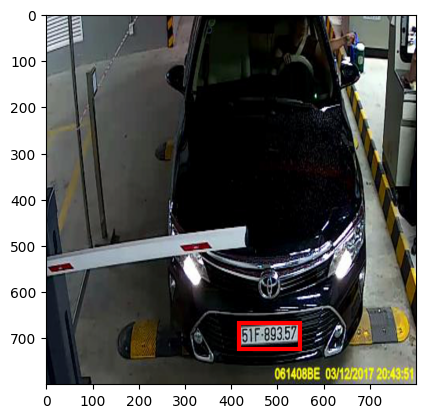

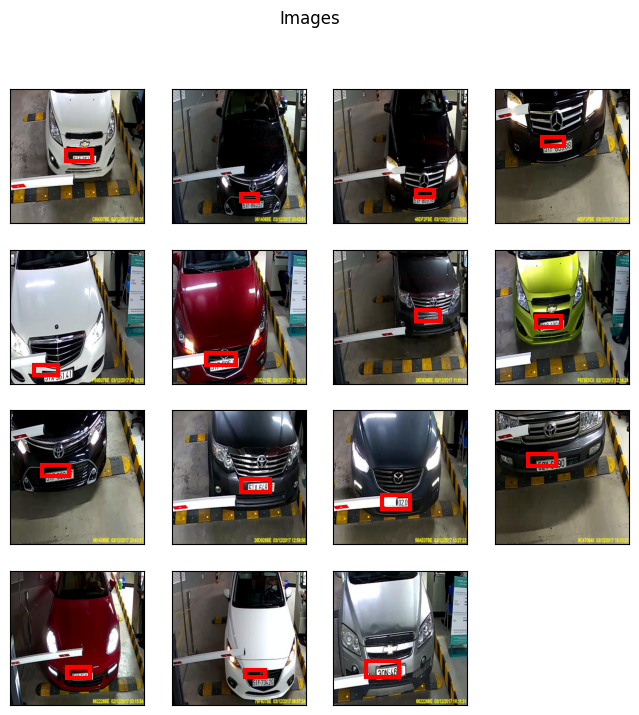

In [ ]:
validate(model, data_loader)

bbox:  tensor([[258.6664, 356.3832, 438.6664, 447.7712]])
labels:  tensor([1])
imageid tensor([11])
torch.Size([3, 800, 800])


<ipython-input-45-c894f503b66e>:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im = im.astype(np.int)


torch.Size([5, 22500, 4]) torch.Size([5, 22500, 2]) torch.Size([5, 22500])
tensor(-7.1227, device='cuda:0', grad_fn=<SelectBackward0>)
tensor([[ 3729, 11022],
        [  885, 20121],
        [ 1002, 16890],
        [ 1686, 18663],
        [ 3135, 18294]], device='cuda:0')
tensor([11022, 20121, 16890, 18663, 18294], device='cuda:0')
11022
tensor([-0.1684, -0.0648,  0.0785,  0.0510], device='cuda:0',
       grad_fn=<SelectBackward0>)
bbox:  torch.Size([22500, 4])
anchors:  (22500, 4)
(22500, 4)
index: 0 bbox: [263.60984511 338.51732298 459.41083748 433.75900444] 
20121
tensor([-0.1781, -0.2904, -0.2041, -0.3202], device='cuda:0',
       grad_fn=<SelectBackward0>)
bbox:  torch.Size([22500, 4])
anchors:  (22500, 4)
(22500, 4)
index: 1 bbox: [461.96309314 652.86418979 609.56175045 718.57509988] 
16890
tensor([-0.1216, -0.3557, -0.1051, -0.1764], device='cuda:0',
       grad_fn=<SelectBackward0>)
bbox:  torch.Size([22500, 4])
anchors:  (22500, 4)
(22500, 4)
index: 2 bbox: [320.50528045 529.8

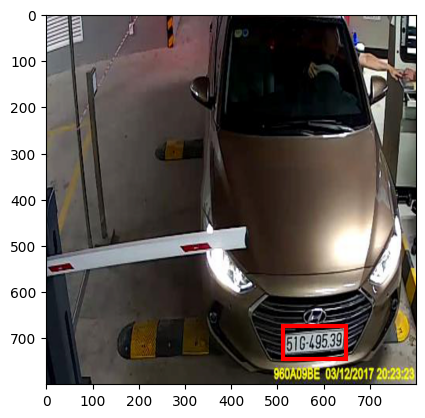

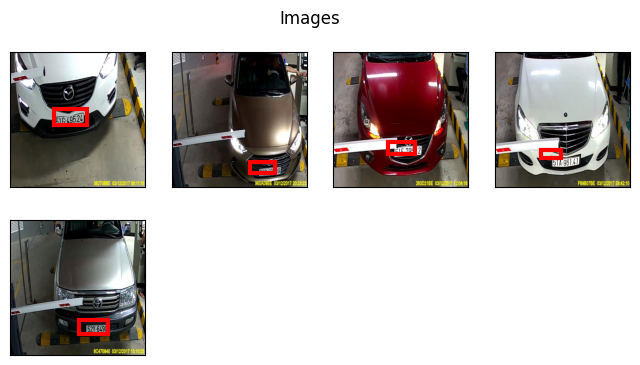

In [ ]:
validate(model, data_loader_val)